# Feature Sets:

Collab link: https://colab.research.google.com/notebooks/mlcc/feature_sets.ipynb

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')

chdf = chdf.reindex(np.random.permutation(chdf.index))



In [0]:
# Preprocessing the features:
def preprocess_features(df):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = df[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]

  # print mean for each pd column:
  # print(selected_features.mean())
  # print(selected_features.std())

  processed_features = selected_features.copy()
  # Create a synthetic feature:
  processed_features['rooms_per_person'] = df['total_rooms'] / df['population']

  # Scaling the features:
  processed_features -= processed_features.mean()
  processed_features /= processed_features.std()

  return processed_features


# Preprocessing the labels:
def preprocess_targets(df):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()  # just to initialise the pd dataframe
  # Scale the target to be in units of thousands of dollars.
  output_targets['median_house_value'] = df['median_house_value'] / 1000.0

  return output_targets


pchdf = preprocess_features(chdf)
ochdf = preprocess_targets(chdf)

print(pchdf.head())
print(ochdf.head())

       latitude  longitude  ...  median_income  rooms_per_person
14478       1.1       -1.3  ...            1.2               0.4
15214       1.0       -1.4  ...           -1.1              -0.2
15980       1.0       -1.4  ...            0.1               0.2
1515       -0.8        1.2  ...            0.7               0.1
5602       -0.7        0.7  ...            2.7               0.8

[5 rows x 9 columns]
       median_house_value
14478               394.4
15214               159.8
15980               500.0
1515                155.5
5602                500.0


In [0]:
# Setting the training set size
train_val_split = 0.8
m_train = int(train_val_split*pchdf.shape[0])
# Setting the validation set size:
m_val = pchdf.shape[0] - m_train

# Splitting DF into training and validation sets:
training_examples = pchdf.head(m_train)
print(training_examples.describe())

training_targets = ochdf.head(m_train)
print(training_targets.describe())

validation_examples = pchdf.tail(m_val)  # we take the last examples using the tail command
print(validation_examples.describe())

validation_targets = ochdf.tail(m_val)
print(validation_targets.describe())


# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

       latitude  longitude  ...  median_income  rooms_per_person
count   13600.0    13600.0  ...        13600.0           13600.0
mean        0.0       -0.0  ...            0.0              -0.0
std         1.0        1.0  ...            1.0               1.0
min        -1.4       -2.3  ...           -1.8              -1.7
25%        -0.8       -1.1  ...           -0.7              -0.4
50%        -0.6        0.5  ...           -0.2              -0.0
75%         1.0        0.8  ...            0.5               0.3
max         3.0        2.5  ...            5.8              45.5

[8 rows x 9 columns]
       median_house_value
count             13600.0
mean                208.1
std                 116.3
min                  15.0
25%                 120.1
50%                 181.2
75%                 265.9
max                 500.0
       latitude  longitude  ...  median_income  rooms_per_person
count    3400.0     3400.0  ...         3400.0            3400.0
mean       -0.0        0.0  .

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,13600.0,13600.0,13600.0,13600.0,13600.0,13600.0,13600.0,13600.0,13600.0
mean,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.4,-2.3,-2.2,-1.2,-1.3,-1.2,-1.3,-1.8,-1.7
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,0.0,-0.2,-0.3,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.3,0.3,0.3,0.5,0.3
max,3.0,2.5,1.9,13.8,14.0,29.8,14.5,5.8,45.5


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,3400.0,3400.0,3400.0,3400.0,3400.0,3400.0,3400.0,3400.0,3400.0
mean,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,0.9,1.0,1.0,1.2
min,-1.4,-2.4,-2.1,-1.2,-1.3,-1.2,-1.3,-1.8,-1.6
25%,-0.8,-1.0,-0.8,-0.5,-0.6,-0.5,-0.6,-0.7,-0.4
50%,-0.7,0.6,-0.0,-0.2,-0.2,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.3,0.3,0.3,0.4,0.3
max,2.9,2.6,1.9,16.2,11.7,12.8,12.2,5.8,42.8


Training targets summary:


,median_house_value
count,13600.0
mean,208.1
std,116.3
min,15.0
25%,120.1
50%,181.2
75%,265.9
max,500.0


Validation targets summary:


,median_house_value
count,3400.0
mean,204.1
std,114.8
min,22.5
25%,116.8
50%,177.5
75%,262.1
max,500.0


Training model:

In [0]:
# Input function:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()  ## TF 1!!!

    return features, labels


# Defining feature columns:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.

    Args:
      input_features: The names of the numerical input features to use.
    Returns:
      A set of feature columns
    """ 
    # return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])  
    return [tf.feature_column.numeric_column(my_feature) for my_feature in input_features]   # set is not needed

# print(construct_feature_columns(training_examples))



# Training model function:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn = lambda : my_input_fn(training_examples, training_targets, batch_size=batch_size, shuffle=True, num_epochs=None)
  predict_training_input_fn = lambda : my_input_fn(training_examples, training_targets, shuffle=False, num_epochs=1)
  predict_validation_input_fn = lambda : my_input_fn(validation_examples, validation_targets, shuffle=False, num_epochs=1)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(training_predictions, training_targets) )
    validation_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(validation_predictions, validation_targets) )
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.grid()
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(training_predictions, training_targets.values, 'o', label='training predicted vs reality' )
  plt.plot(validation_predictions, validation_targets.values, 'o', label='validation predicted vs reality')
  plt.legend()
  plt.grid()
  plt.ylabel("targetss")
  plt.xlabel("predictions")
  plt.title("Predicted vss Targets")

  plt.show()

  return linear_regressor

#Task 1: Develop a Good Feature Set

Generating correlation matrix between features:

In [0]:
corrdf =  training_examples.copy()
corrdf['target'] = training_targets['median_house_value']

# corrdf.corr()
display.display(corrdf.corr(method ='pearson'))


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


In [0]:
#little test to create a df from selected columns:
reddf = corrdf[['latitude', 'longitude']]
display.display(reddf)

,latitude,longitude
14478,1.1,-1.3
15214,1.0,-1.4
15980,1.0,-1.4
1515,-0.8,1.2
5602,-0.7,0.7
...,...,...
11835,1.4,-0.9
10126,0.5,-0.1
692,-1.2,1.3
16491,1.2,-1.5


Training model...
RMSE (on training data):
  period 00 : 141.98
  period 01 : 88.19
  period 02 : 80.58
  period 03 : 78.89
  period 04 : 77.22
  period 05 : 77.01
  period 06 : 77.53
  period 07 : 76.37
  period 08 : 76.22
  period 09 : 75.88
Model training finished.


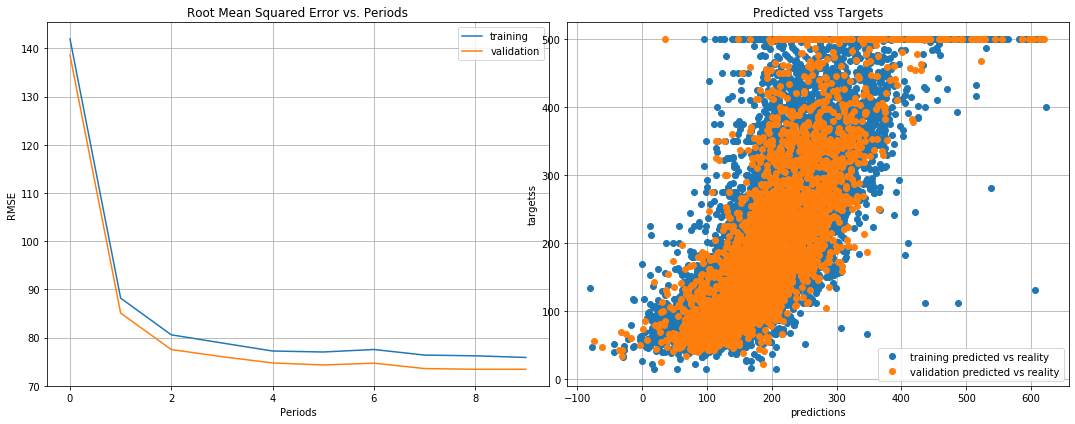

In [0]:
chosen_features = ['latitude', 'longitude', 'housing_median_age', 'population', 'median_income', 'rooms_per_person']
chosen_features = ['latitude', 'longitude', 'population', 'median_income']

assert chosen_features, "You must select at least one feature!"


chosen_training_examples = training_examples[chosen_features]
chosen_validation_examples = validation_examples[chosen_features]

# Call the training model:
learning_rate = 0.6 #0.3
steps = 500
batch_size = 5

calibration_data = train_model( learning_rate, steps, batch_size, training_examples=chosen_training_examples, training_targets=training_targets, validation_examples=chosen_validation_examples, validation_targets=validation_targets )

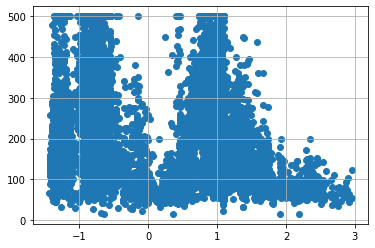

count   13600.0
mean        0.0
std         1.0
min        -1.4
25%        -0.8
50%        -0.6
75%         1.0
max         3.0
Name: latitude, dtype: float64

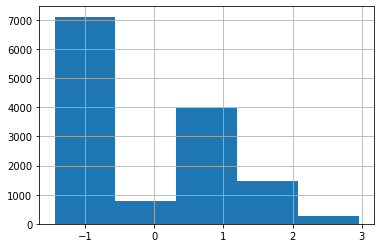

In [0]:
plt.scatter(training_examples['latitude'], training_targets['median_house_value'])
plt.grid()
plt.show()

display.display(training_examples['latitude'].describe())

display.display(training_examples['latitude'].hist(bins=5))

Test to get index using a condition rule in a series.
Then apply a data value in those rows:

In [0]:
# initialising a feature:
training_examples['latitude bin 1'] = 0.0

# get the indices of conditional element data:
print(training_examples.latitude<-1)
print(training_examples['latitude'].loc[training_examples.latitude<-1].shape)
print(training_examples.loc[training_examples['latitude']<-1].shape)
print(training_examples.loc[training_examples.latitude<-1].shape)
# training_examples.latitude is the same as training_examples['latitude']

print(training_examples['latitude bin 1'].loc[training_examples.latitude<-1].shape)

print((training_examples.latitude<=-1) & (training_examples.latitude<0))
# print(training_examples['latitude bin 2'].loc[(training_examples.latitude>=-1) & (training_examples.latitude<0)].shape)

# assigning a value to those indices:
training_examples['latitude bin 1'].loc[training_examples.latitude<-1] = 1.0

# training_examples.loc[training_examples.latitude<-1, ['latitude bin 1']] = 1.0


# training_examples.head()

display.display(pchdf.iloc[2-1:3+2] )

[kk, kk2] = [pchdf['latitude'], pchdf['longitude']]
print(kk.shape)
print(kk2.shape)

14478    False
15214    False
15980    False
1515     False
5602     False
         ...  
11835    False
10126    False
692       True
16491    False
1323      True
Name: latitude, Length: 13600, dtype: bool
(1200,)
(1200, 10)
(1200, 10)
(1200,)
14478    False
15214    False
15980    False
1515     False
5602     False
         ...  
11835    False
10126    False
692       True
16491    False
1323      True
Name: latitude, Length: 13600, dtype: bool


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
15214,1.0,-1.4,1.1,-0.5,-0.4,-0.4,-0.4,-1.1,-0.2
15980,1.0,-1.4,1.9,-0.5,-0.1,-0.6,-0.1,0.1,0.2
1515,-0.8,1.2,-1.9,2.6,1.7,2.2,1.7,0.7,0.1
5602,-0.7,0.7,1.1,0.7,0.1,0.0,0.2,2.7,0.8


(17000,)
(17000,)


In [0]:
# Binning a feature:
pchdf['latitude bin 1'] = 0.0
pchdf['latitude bin 2'] = 0.0
pchdf['latitude bin 3'] = 0.0
pchdf['latitude bin 4'] = 0.0
pchdf['latitude bin 5'] = 0.0

pchdf['latitude bin 1'].loc[pchdf['latitude']<-1] = 1.0
pchdf['latitude bin 2'].loc[(pchdf.latitude>=-1) & (pchdf['latitude']<0)] = 1.0
pchdf['latitude bin 3'].loc[(pchdf['latitude']>=0) & (pchdf.latitude<1)] = 1.0
pchdf['latitude bin 4'].loc[(pchdf.latitude>=1) & (pchdf.latitude<2)] = 1.0
pchdf['latitude bin 5'].loc[pchdf['latitude']>=2] = 1.0

pchdf.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,latitude bin 1,latitude bin 2,latitude bin 3,latitude bin 4,latitude bin 5
14478,1.1,-1.3,0.4,2.0,1.3,1.3,1.6,1.2,0.4,0.0,0.0,0.0,1.0,0.0
15214,1.0,-1.4,1.1,-0.5,-0.4,-0.4,-0.4,-1.1,-0.2,0.0,0.0,0.0,1.0,0.0
15980,1.0,-1.4,1.9,-0.5,-0.1,-0.6,-0.1,0.1,0.2,0.0,0.0,0.0,1.0,0.0
1515,-0.8,1.2,-1.9,2.6,1.7,2.2,1.7,0.7,0.1,0.0,1.0,0.0,0.0,0.0
5602,-0.7,0.7,1.1,0.7,0.1,0.0,0.2,2.7,0.8,0.0,1.0,0.0,0.0,0.0


In [0]:
def TrainValTestDataSplit(feat_df, targ_df, train_percentage, val_percentage, test_percentage):

  # Data reshuffled randomly, just in case it hasn't been done yet:
  my_index = np.random.permutation(feat_df.index)
  feat_df = feat_df.reindex(my_index)
  targ_df = targ_df.reindex(my_index)

  # Training, Validation and Test dataset sizes:
  m_train = int(train_percentage*feat_df.shape[0])
  m_test = int(test_percentage*feat_df.shape[0])
  m_val = feat_df.shape[0] - m_train - m_test


  # Splitting DF into training and validation sets:
  training_examples = feat_df.head(m_train)
  training_targets = targ_df.head(m_train)
 
  validation_examples = feat_df.iloc[m_train:m_train+m_val] 
  validation_targets = targ_df.iloc[m_train:m_train+m_val]

  test_examples = feat_df.tail(m_test)  # we take the last examples using the tail command
  test_targets = targ_df.tail(m_test)

  return training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets


In [0]:
def FeatureScaling(df):
  
  # Scaling the features:
  scaled_features -= df.mean()
  scaled_features /= scaled_features.std()

  return scaled_features


In [0]:
def BinFeature(df, feature_col, ends):
  """ Function to bin a feature into ranges from end to end:
      - df: dataframe
      - feature_col: name of the feature that needs binning
      - ends: a 2 array vector with the lower and upper ends.
  """

  # Creating the bin ranges with a zip:    
  ranges = zip(range(ends[0], ends[1]), range(ends[0]+1, ends[1]+1))

  # Splitting the feature into the different bins:
  for r in ranges:
    df[feature_col+"_%d_to_%d" %r] = df[feature_col].apply( lambda val : 1.0 if val>=r[0] and val<r[1] else 0.0 )

  # Removing the non-binned feature:
  del df[feature_col]

  return df
  

In [0]:
# Loading the data:
chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')
chdf = chdf.reindex(np.random.permutation(chdf.index))


# Processing the data:
pchdf = preprocess_features(chdf)  # def preprocess_features
ochdf = preprocess_targets(chdf)

print(pchdf.head())
print(ochdf.head())


# Chosen features:
chosen_features = ['latitude', 'median_income']
pchdf = pchdf[chosen_features]


# Binning 'Latitude' feature:
# pchdf['latitude bin 1'] = 0.0
# pchdf['latitude bin 2'] = 0.0
# pchdf['latitude bin 3'] = 0.0
# pchdf['latitude bin 4'] = 0.0
# pchdf['latitude bin 5'] = 0.0

# pchdf['latitude bin 1'].loc[pchdf['latitude']<-1] = 1.0
# pchdf['latitude bin 2'].loc[(pchdf.latitude>=-1) & (pchdf['latitude']<0)] = 1.0
# pchdf['latitude bin 3'].loc[(pchdf['latitude']>=0) & (pchdf.latitude<1)] = 1.0
# pchdf['latitude bin 4'].loc[(pchdf.latitude>=1) & (pchdf.latitude<2)] = 1.0
# pchdf['latitude bin 5'].loc[pchdf['latitude']>=2] = 1.0
pchdf = BinFeature(pchdf, 'latitude', [-2, 3])   # def BinFeature

display.display(pchdf.head())


# Splitting the dataframe (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.25
test_percentage = 0.0

[training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets] = TrainValTestDataSplit(pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit


# Describing the different data sets:
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Test examples summary:")
display.display(test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

       latitude  longitude  ...  median_income  rooms_per_person
12810       0.8       -1.1  ...            1.9               0.6
10751       2.2       -0.5  ...           -0.8              -0.0
9684        0.5        0.0  ...           -0.9              -0.8
1559       -0.8        1.2  ...           -0.7              -0.5
10866       0.7       -0.6  ...           -1.0              -0.2

[5 rows x 9 columns]
       median_house_value
12810               456.5
10751                70.2
9684                 58.9
1559                500.0
10866               140.6


,median_income,latitude_-2_to_-1,latitude_-1_to_0,latitude_0_to_1,latitude_1_to_2,latitude_2_to_3
12810,1.9,0.0,0.0,1.0,0.0,0.0
10751,-0.8,0.0,0.0,0.0,0.0,1.0
9684,-0.9,0.0,0.0,1.0,0.0,0.0
1559,-0.7,0.0,1.0,0.0,0.0,0.0
10866,-1.0,0.0,0.0,1.0,0.0,0.0


Training examples summary:


,median_income,latitude_-2_to_-1,latitude_-1_to_0,latitude_0_to_1,latitude_1_to_2,latitude_2_to_3
count,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0
mean,-0.0,0.1,0.5,0.2,0.2,0.0
std,1.0,0.3,0.5,0.4,0.4,0.1
min,-1.8,0.0,0.0,0.0,0.0,0.0
25%,-0.7,0.0,0.0,0.0,0.0,0.0
50%,-0.2,0.0,0.0,0.0,0.0,0.0
75%,0.5,0.0,1.0,0.0,0.0,0.0
max,5.8,1.0,1.0,1.0,1.0,1.0


Validation examples summary:


,median_income,latitude_-2_to_-1,latitude_-1_to_0,latitude_0_to_1,latitude_1_to_2,latitude_2_to_3
count,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0
mean,0.0,0.1,0.5,0.2,0.2,0.0
std,1.0,0.3,0.5,0.4,0.4,0.1
min,-1.8,0.0,0.0,0.0,0.0,0.0
25%,-0.7,0.0,0.0,0.0,0.0,0.0
50%,-0.2,0.0,0.0,0.0,0.0,0.0
75%,0.5,0.0,1.0,0.0,0.0,0.0
max,5.8,1.0,1.0,1.0,1.0,1.0


Test examples summary:


,median_income,latitude_-2_to_-1,latitude_-1_to_0,latitude_0_to_1,latitude_1_to_2,latitude_2_to_3
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,nan,nan,nan,nan,nan,nan
std,nan,nan,nan,nan,nan,nan
min,nan,nan,nan,nan,nan,nan
25%,nan,nan,nan,nan,nan,nan
50%,nan,nan,nan,nan,nan,nan
75%,nan,nan,nan,nan,nan,nan
max,nan,nan,nan,nan,nan,nan


Training targets summary:


,median_house_value
count,12750.0
mean,206.9
std,115.4
min,15.0
25%,120.1
50%,180.1
75%,263.6
max,500.0


Validation targets summary:


,median_house_value
count,4250.0
mean,208.4
std,117.7
min,15.0
25%,118.1
50%,180.9
75%,268.0
max,500.0


Test targets summary:


,median_house_value
count,0.0
mean,nan
std,nan
min,nan
25%,nan
50%,nan
75%,nan
max,nan


Training model...
RMSE (on training data):
  period 00 : 114.67
  period 01 : 85.19
  period 02 : 83.53
  period 03 : 83.37
  period 04 : 83.39
  period 05 : 84.04
  period 06 : 83.18
  period 07 : 83.73
  period 08 : 84.27
  period 09 : 83.23
Model training finished.


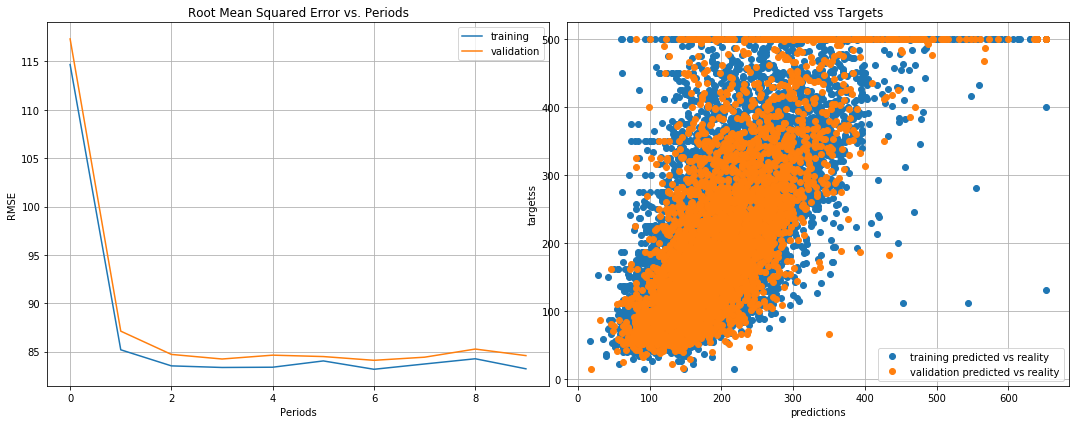

In [0]:
# Call the training model:
learning_rate = 0.6 #0.3
steps = 500
batch_size = 5

calibration_data = train_model( learning_rate, steps, batch_size, training_examples=training_examples, training_targets=training_targets, validation_examples=validation_examples, validation_targets=validation_targets )